#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements covergence diagnositics of the competing methods and
### the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import numpy as np
import pandas as pd
from TAVIE import *
from CompetingMethods import *
import pandas as pd
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt

### Convergence of TAVIE and BBVI for Laplace likelihood (SSG Type I)

For BBVI we use three different BBVI algorithms:
* a vanilla BBVI algorithm,
* a patience BBVI algorithm tracking the convergence using the relative change in the ELBO, i.e., convergence is reported if the relative ELBO does not change over a tolerance across patience number of steps, and
* a full covariance structured BBVI algorithm, where the BBVI uses a full covariance structured matrix with the same patience relative ELBO tracking for monitorinf convergence.

In [2]:
# Simulated data
n = 10000
p = 5
tau2 = 8

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error = np.random.laplace(size=n, loc=0.0, scale = 1/np.sqrt(tau2))
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for laplace likelihood
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
laplace_model.fit(X, y, verbose=False) # fit the TAVIE model
res1 = laplace_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
ELBO = laplace_model.get_elbo() # get the ELBO across iterations
# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = laplace_model.get_variational_estimates()
beta_est1, tau2_est1 = res1 # TAVIE estimates

# BBVI vanilla estimator,  BBVI estimator with patience, and BBVI estimator with full covariance structure
X_bbvi = np.column_stack((np.ones(n), X))
Sigma_prior = np.eye(p+1)
a = 0.05
b = 0.05
res2 = BBVI_Laplace(X_bbvi, y)
res3 = BBVI_Laplace_patience(X_bbvi, y)
res4 = BBVI_Laplace_fullcov(X_bbvi, y, Sigma_prior=Sigma_prior, a=a, b=b)
beta_est2 = res2['beta_mean']
tau2_est2 = res2['tau2_mean']
beta_est3 = res3['beta_mean']
tau2_est3 = res3['tau2_mean']
beta_est4 = res4['beta_mean']
tau2_est4 = res4['tau2_mean']
elbo_BBVI = res2['elbo_hist']
elbo_BBVI_patience = res3['elbo_hist']
elbo_BBVI_fullcov = res4['elbo_hist']

# displaying the TAVIE and BBVI estimates
param_names = ["beta0"] + [f"beta{i}" for i in range(1, len(beta_true))] + ["tau2"]

# Stack true and estimated values
true_vals   = np.concatenate([beta_true,  [tau2]])
tavie_vals  = np.concatenate([beta_est1,  [tau2_est1]])
bbvi_vals   = np.concatenate([beta_est2,  [tau2_est2]])
bbvi_patience_vals = np.concatenate([beta_est3,  [tau2_est3]])
bbvi_fullcov_vals = np.concatenate([beta_est4,  [tau2_est4]])

# Construct the DataFrame of results
df_estimates = pd.DataFrame(
    {
        "true":  true_vals,
        "TAVIE": tavie_vals,
        "BBVI":  bbvi_vals,
        "BBVI_patience": bbvi_patience_vals,
        "BBVI_fullcov": bbvi_fullcov_vals
    },
    index=param_names
)

df_estimates

Early stopping at iter 3074: no ELBO gain ≥ 1e-08 for 500 iters.
Early stopping at iter 1947: no ELBO gain ≥ 1e-08 for 500 iters.


,true,TAVIE,BBVI,BBVI_patience,BBVI_fullcov
beta0,0.565380,0.564436,0.570357,0.572969,0.560108
beta1,-0.721888,-0.718873,-0.722818,-0.721438,-0.728546
beta2,-1.575338,-1.567756,-1.566467,-1.571956,-1.558042
beta3,0.983272,0.988661,0.993183,0.990908,1.009561
beta4,-0.897994,-0.898624,-0.904287,-0.897619,-0.889056
beta5,1.390996,1.395136,1.392080,1.388958,1.393518
tau2,8.000000,7.900746,7.968588,8.559097,7.688533


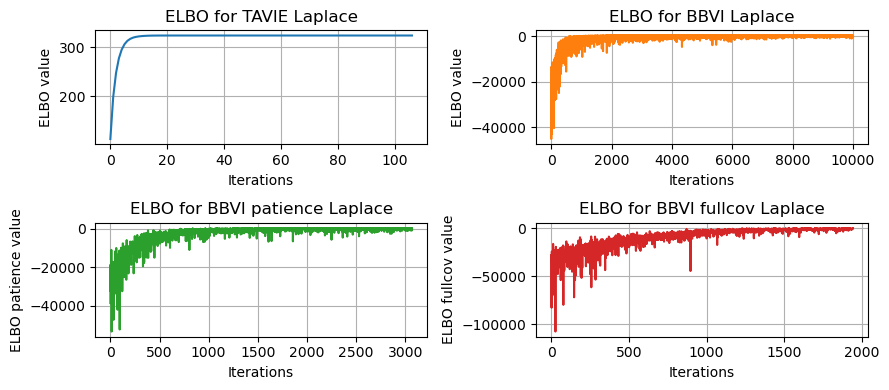

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(9, 4), sharex=False, sharey=False)

# TAVIE ELBO
axes[0, 0].plot(ELBO[6:], color='C0')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('ELBO value')
axes[0, 0].set_title("ELBO for TAVIE Laplace")
axes[0, 0].grid(True)

# BBVI ELBO
axes[0, 1].plot(elbo_BBVI[6:], color='C1')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('ELBO value')
axes[0, 1].set_title("ELBO for BBVI Laplace")
axes[0, 1].grid(True)

# BBVI patience ELBO
axes[1, 0].plot(elbo_BBVI_patience[6:], color='C2')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('ELBO patience value')
axes[1, 0].set_title("ELBO for BBVI patience Laplace")
axes[1, 0].grid(True)

# BBVI fullcov ELBO
axes[1, 1].plot(elbo_BBVI_fullcov[6:], color='C3')
axes[1, 1].set_xlabel('Iterations')
axes[1, 1].set_ylabel('ELBO fullcov value')
axes[1, 1].set_title("ELBO for BBVI fullcov Laplace")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### Convergence of TAVIE and BBVI for Student's t likelihood (SSG Type I)

For BBVI we use three different BBVI algorithms:
* a vanilla BBVI algorithm,
* a patience BBVI algorithm tracking the convergence using the relative change in the ELBO, i.e., convergence is reported if the relative ELBO does not change over a tolerance across patience number of steps, and
* a full covariance structured BBVI algorithm, where the BBVI uses a full covariance structured matrix with the same patience relative ELBO tracking for monitorinf convergence.

In [9]:
# Simulated data
n = 10000
p = 5
tau2 = 8
nu_true = 5

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error =  np.random.standard_t(size = n, df = nu_true) * 1/np.sqrt(tau2)
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for student's-t likelihood
student_model = TAVIE_loc_scale(family="student", fit_intercept=True)
student_model.fit(X, y, nu=nu_true, verbose=False) # fit the TAVIE model
res1 = student_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
ELBO = student_model.get_elbo() # get the ELBO across iterations
# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = student_model.get_variational_estimates()
beta_est1, tau2_est1 = res1

# BBVI estimator, BBVI patience estimator, and BBVI full covariance estimator
X_bbvi = np.column_stack((np.ones(n), X))
Sigma_prior = np.eye(p+1)
a0 = 0.05
b0 = 0.05
res2 = BBVI_student(X_bbvi, y, nu=nu_true)
res3 = BBVI_student_patience(X_bbvi, y, nu=nu_true)
res4 = BBVI_student_fullcov(X_bbvi, y, nu=nu_true, Sigma_prior=Sigma_prior, a0=a0, b0=b0)
beta_est2 = res2['beta_mean']
tau2_est2 = res2['tau2_mean']
beta_est3 = res3['beta_mean']
tau2_est3 = res3['tau2_mean']
beta_est4 = res4['beta_mean']
tau2_est4 = res4['tau2_mean']
ELBO_BBVI = res2['elbo_hist']
ELBO_BBVI_patience = res3['elbo_hist']
ELBO_BBVI_fullcov = res4['elbo_hist']

# displaying the TAVIE and BBVI estimates
param_names = ["beta0"] + [f"beta{i}" for i in range(1, len(beta_true))] + ["tau2"]

# Stack true and estimated values
true_vals   = np.concatenate([beta_true,  [tau2]])
tavie_vals  = np.concatenate([beta_est1,  [tau2_est1]])
bbvi_vals   = np.concatenate([beta_est2,  [tau2_est2]])
bbvi_patience_vals   = np.concatenate([beta_est3,  [tau2_est3]])
bbvi_fullcov_vals   = np.concatenate([beta_est4,  [tau2_est4]])

# Construct the DataFrame of results
df_estimates = pd.DataFrame(
    {
        "true":  true_vals,
        "TAVIE": tavie_vals,
        "BBVI":  bbvi_vals,
        "BBVI_patience": bbvi_patience_vals,
        "BBVI_fullcov": bbvi_fullcov_vals
    },
    index=param_names
)

df_estimates

Early stopping at iter 1775: no ELBO gain ≥ 1e-08 for 500 iters.
Early stopping at iter 2969: no ELBO gain ≥ 1e-08 for 500 iters.


,true,TAVIE,BBVI,BBVI_patience,BBVI_fullcov
beta0,-1.293325,-1.288161,-1.289884,-1.289991,-1.296000
beta1,1.309370,1.308308,1.303334,1.294890,1.302416
beta2,-0.319239,-0.321802,-0.324298,-0.313099,-0.332472
beta3,-1.440583,-1.439597,-1.444131,-1.442915,-1.449979
beta4,0.901445,0.900572,0.901240,0.893826,0.902558
beta5,0.420859,0.427885,0.424919,0.428548,0.432043
tau2,8.000000,7.905719,7.981525,9.275221,8.600723


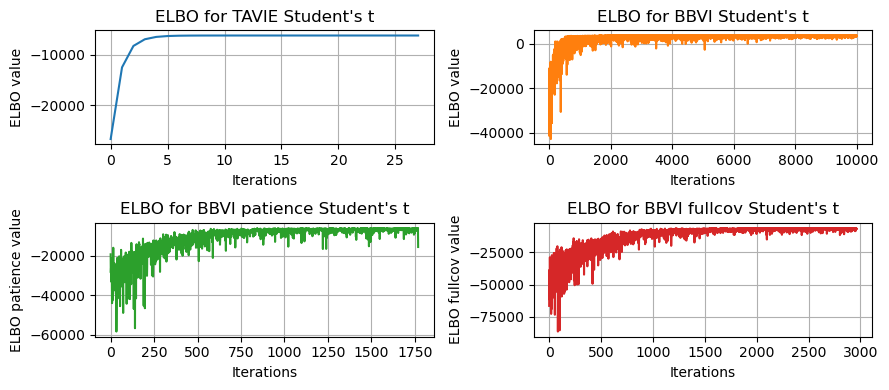

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(9, 4), sharex=False, sharey=False)

# TAVIE ELBO
axes[0, 0].plot(ELBO[6:], color='C0')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('ELBO value')
axes[0, 0].set_title("ELBO for TAVIE Student's t")
axes[0, 0].grid(True)

# BBVI ELBO
axes[0, 1].plot(ELBO_BBVI[6:], color='C1')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('ELBO value')
axes[0, 1].set_title("ELBO for BBVI Student's t")
axes[0, 1].grid(True)

# BBVI patience ELBO
axes[1, 0].plot(ELBO_BBVI_patience[6:], color='C2')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('ELBO patience value')
axes[1, 0].set_title("ELBO for BBVI patience Student's t")
axes[1, 0].grid(True)

# BBVI fullcov ELBO
axes[1, 1].plot(ELBO_BBVI_fullcov[6:], color='C3')
axes[1, 1].set_xlabel('Iterations')
axes[1, 1].set_ylabel('ELBO fullcov value')
axes[1, 1].set_title("ELBO for BBVI fullcov Student's t")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()